<a href="https://colab.research.google.com/github/Andiko-K/SkinColorDetection/blob/main/transfer-learning/model/skincolor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import zipfile
import os, shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import random
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Installing Dataset

In [ ]:
!gdown --id 1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT
From (redirected): https://drive.google.com/uc?id=1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT&confirm=t&uuid=b85a0b45-0882-42c6-9c30-a839a68281d8
To: /content/mst_dataset.zip
100% 313M/313M [00:04<00:00, 72.5MB/s]


# Data Exploration

In [ ]:
local_file = 'mst_dataset.zip'
destination = './mst_datasets/'

zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall(destination)
zip_ref.close()

# Data Splitting

In [ ]:
original_dir = './mst_datasets'
def split_data(original_dir = original_dir, train_split = None,
               train_num = None, val_num = None):
  train_dir = './datasets/train/'
  val_dir = './datasets/validation'

  os.makedirs(train_dir, exist_ok = True)
  os.makedirs(val_dir, exist_ok = True)

  for category in os.listdir(original_dir):
    train_cat_dir = os.path.join(train_dir, category)
    val_cat_dir = os.path.join(val_dir, category)

    os.makedirs(train_cat_dir, exist_ok = True)
    os.makedirs(val_cat_dir, exist_ok = True)

    #Get Images List and Shuffle
    category_dir = os.path.join(original_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    #Split images if train_split is specified
    if train_split is not None:
      split_index = int(train_split*len(images))
      train_images = images[:split_index]
      val_images = images[split_index:]

    #Split images if number of train and val is specified
    else:
      get_images = random.sample(images, train_num + val_num)
      train_images = get_images[:train_num]
      val_images = get_images[train_num:]

    #Replacing The File
    for image in train_images:
        src = os.path.join(category_dir, image)
        dest = os.path.join(train_dir, category, image)
        os.rename(src, dest)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dest = os.path.join(val_dir, category, image)
        os.rename(src, dest)

  return train_dir, val_dir




In [ ]:
train_dir, val_dir = split_data(train_split = .8)

# Tensorflow Hub Model

In [ ]:
transfer_model = ('https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2', 128)

# Generator

In [ ]:
def image_generator(train_dir = train_dir, val_dir = val_dir, transfer_model = None,
                    batch_size = 32):
  module_handle, shape = transfer_model
  training_datagen = ImageDataGenerator(
      rescale = 1./255,
      horizontal_flip = True,
      zoom_range = .2,
      shear_range = .2,
      fill_mode = 'nearest'
  )
  train_generator = training_datagen.flow_from_directory(
      directory = train_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
  )

  validation_datagen = ImageDataGenerator(
      rescale = 1./255
  )
  val_generator = validation_datagen.flow_from_directory(
      directory = val_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
  )

  return train_generator, val_generator

# Define Model

In [ ]:
def create_model(transfer_model = None):
  module_handle, shape = transfer_model
  image_size = (shape, shape)
  feature_extractor = hub.KerasLayer(module_handle, input_shape = image_size + (3,))

  #For Testing, might as well set trainable to false
  model = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dropout(.4),
      tf.keras.layers.Dense(10, activation = 'softmax')
  ])

  optimizer = tf.keras.optimizers.SGD(learning_rate = .002, momentum = .9)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

# Train Model

In [ ]:
train_generator, val_generator = image_generator(transfer_model = transfer_model)
model = create_model(transfer_model = transfer_model)

Found 1091 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


In [ ]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min',
                                             restore_best_weights = True, start_from_epoch = 10,
                                             min_delta = .001)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', min_delta = .001)

model.fit(train_generator, epochs = 50, callbacks = [ReduceLR, EarlyStop],
          validation_data = val_generator)

Epoch 1/50
35/35 [==============================] - 19s 335ms/step - loss: 1.9468 - accuracy: 0.3584 - val_loss: 1.1186 - val_accuracy: 0.6536 - lr: 0.0020
Epoch 2/50
35/35 [==============================] - 9s 264ms/step - loss: 0.8984 - accuracy: 0.7140 - val_loss: 0.5689 - val_accuracy: 0.8821 - lr: 0.0020
Epoch 3/50
35/35 [==============================] - 9s 271ms/step - loss: 0.5582 - accuracy: 0.8460 - val_loss: 0.3731 - val_accuracy: 0.9464 - lr: 0.0020
Epoch 4/50
35/35 [==============================] - 9s 256ms/step - loss: 0.4782 - accuracy: 0.8671 - val_loss: 0.3159 - val_accuracy: 0.9500 - lr: 0.0020
Epoch 5/50
35/35 [==============================] - 9s 262ms/step - loss: 0.3622 - accuracy: 0.9065 - val_loss: 0.2665 - val_accuracy: 0.9571 - lr: 0.0020
Epoch 6/50
35/35 [==============================] - 9s 248ms/step - loss: 0.3295 - accuracy: 0.9157 - val_loss: 0.2407 - val_accuracy: 0.9571 - lr: 0.0020
Epoch 7/50
35/35 [==============================] - 10s 283ms/step - 

# Save Model

In [ ]:
model_path = './model/skincolor_mobilev2.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test Upload

In [ ]:
model_up = tf.keras.models.load_model(
    './skincolor_mobilev2.h5', custom_objects={'KerasLayer': hub.KerasLayer},
)

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def make_cm( model = model):
  predicted_classes = []
  true_classes = []
  val_generator.reset()

  for batch_index in range(len(val_generator)):
    images, labels = next(val_generator)
    predictions =np.argmax(model.predict(images), axis = 1)

    predicted_classes.extend(predictions)
    true_classes.extend(labels)

  predicted_classes = np.array(predicted_classes)
  true_classes = np.array(true_classes)
  cm = confusion_matrix(true_classes, predicted_classes)
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  class_labels = list(val_generator.class_indices.keys())

  #Plot Confusion Matrix
  plt.figure(figsize = (10,10))
  sns.heatmap(cm, annot = True, cmap = 'YlGnBu',
           xticklabels = class_labels, yticklabels = class_labels )
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion matrix')
  plt.show()

1/1 [==============================] - 0s 24ms/step


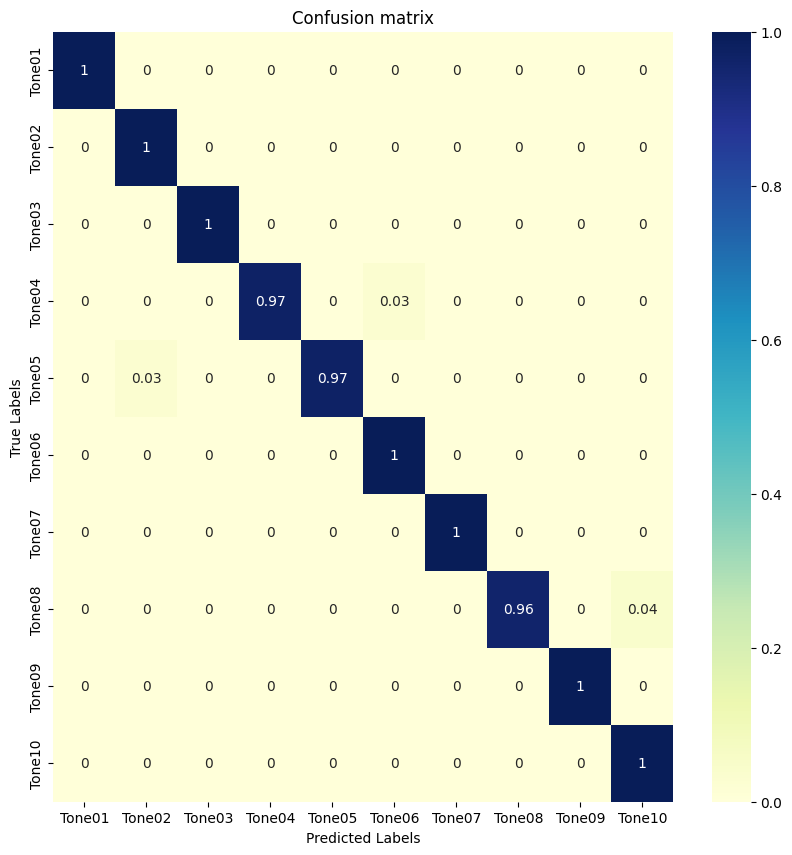

In [ ]:
make_cm()

1/1 [==============================] - 1s 1s/step


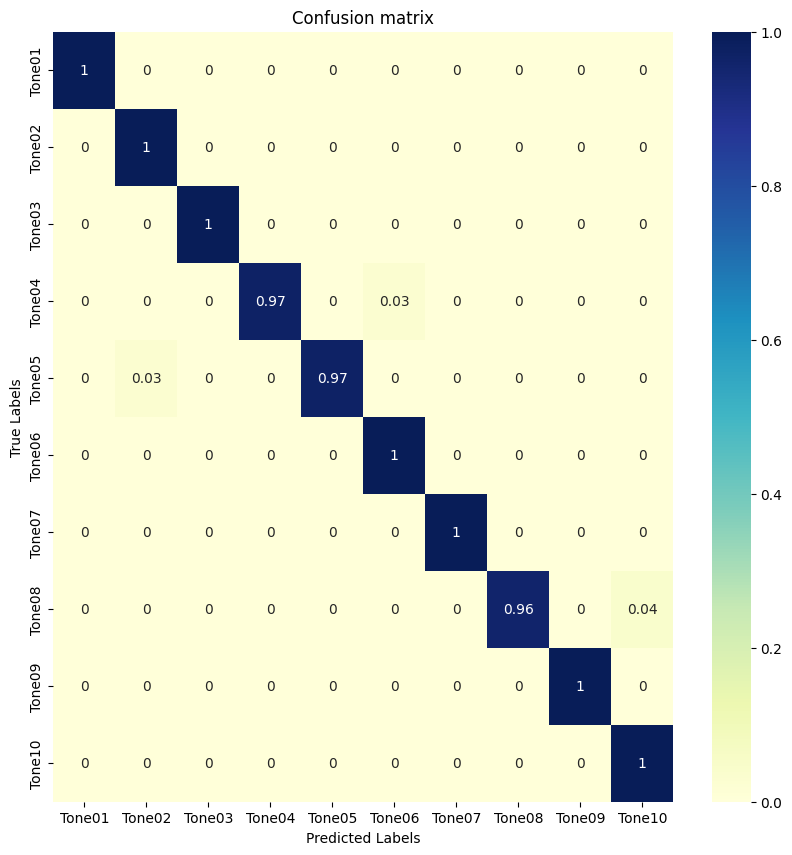

In [ ]:
make_cm(model_up)